In [95]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scienceplots
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import StateSpace, lsim
from torch import nn
import torch
import torchvision
plt.rcParams.update({
    "text.usetex": True,
    })

from scipy.interpolate import interp1d
stadnard_backend = plt.get_backend()
plt.switch_backend(stadnard_backend)

#### Best Hyperparameters so far:

hidden_dim = 8,     lr = 0.01       numbers_systems = 8,        epochs = 800        batch_size = 16

definition of the APRBS:

In [96]:
#create own aprbs signal 

def APRBS(t, amin = -1, amax = 1, holdmin=1, holdmax=25):
    
    samples_left = len(t)
    dt = t[1]-t[0]
    buf = np.array([])
    stacked_N = 0
    debug_counter = 1

    while samples_left > holdmin/dt:
        amplitude = np.random.rand()*(amax-amin) - (amax-amin)/2    #shift the uniform distribution between amin and amax
        holdtime = np.random.randint(holdmin,holdmax)
        current_N = int(holdtime/dt)
        stacked_N += current_N
        samples_left = samples_left - current_N

        if samples_left < holdmin/dt:
            break
        
        current_signal = np.ones(current_N)*amplitude
        buf = np.concatenate((buf,current_signal))
        debug_counter +=1

    amplitude = np.random.rand()*(amax-amin) - (amax-amin)/2    #shift the uniform distribution between amin and amax
    current_signal = np.ones(int(len(t) - len(buf)))*amplitude
    buf = np.concatenate((buf,current_signal)) 

    return buf 

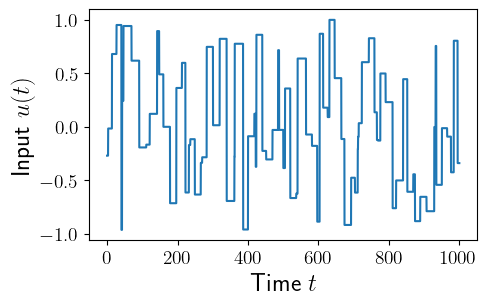

In [97]:
t = np.linspace(0,1000,10_000)
u = APRBS(t)

plt.figure(figsize=(5, 3))
plt.plot(t, u)
plt.xlabel(r'Time $t$', fontsize=18, fontfamily='serif')  # Customize fontsize and font family for x-label
plt.ylabel(r'Input $u(t)$', fontsize=18, fontfamily='serif')  # Customize fontsize and font family for y-label
# Set fontsize for x and y ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Change global font properties (optional)
#plt.rc('font', size=14, family='sans-serif')
plt.show()

In [133]:
def runSimulation(t, torch_tensor=False, batchsize = 1, k=1, X0 = [1 + np.random.rand()*2, np.random.rand()*2, np.random.rand()/2, np.random.rand()*2  ]):
    # parameters
    m = 0.1  # mass of the pendulum
    k_spring = 5  # spring constant
    b = 1.2  # damping coefficient
    f = 1.1  # air friction
    g = 9.81  # acceleration due to gravity
    r0 = 1  # natural length of the spring
    g1 = 1 #input strength of the first input
    g2 = 1 #input strength of the second input

    t_limit = t[-1]

    # system of differential equations
    def system(y, t, u, t_limit):
        if t > t_limit:    
            u = 0  # Set u to 0 if t is larger than last value of t
        else:
            u = u_interp(t) 
        x1, x2, x3, x4,  = y
        dx1 = x2
        dx2 = (m*g*np.cos(x3) - k_spring*(x1 - r0) - b*x2 + m*x1*x4**2) / m + u
        dx3 = x4
        dx4 = (-2*x2*x4 - g*np.sin(x3) - x3*((m*g*np.cos(x3) - k_spring*(x1 - r0) - b*x2 + m*x1*x4**2) / m) - f*x4) / (x1) + u
        #dx4 = (-2*x2*x4 - g*np.sin(x3)) / (x1)
        return [dx1, dx2, dx3, dx4]

    number_states = 4
    number_samples = len(t)
    n = number_samples-k
    X = np.zeros((n,batchsize,number_states+1))
    Y = np.zeros((n,batchsize,number_states+1))

    for i in range(batchsize):
        # initial conditions
        x1_0 = X0[0]  # the pendulum starts at the natural length of the spring
        x2_0 = X0[1] # the pendulum starts at rest
        x3_0 = X0[2]  # the pendulum is slightly displaced from the vertical position
        x4_0 = X0[3]  # the pendulum starts at rest

        # solve ODE
        u = APRBS(t)
        u_interp = interp1d(t, u)  # Create an interpolation function for the input array u
        y = odeint(system, [x1_0, x2_0, x3_0, x4_0], t, args=(u_interp, t_limit))

        new_x = y[:-k]
        u_x = u[:-k]
        u_x = u_x.reshape(-1,1)
        new_y = y[k:]
        u_y = u[k:]
        u_y = u_x.reshape(-1,1)

        X[:,i,:] = np.hstack((new_x, u_x))
        Y[:,i,:] = np.hstack((new_y, u_y))

    if torch_tensor:

        input_tensor = torch.from_numpy(X).float()
        target_tensor = torch.from_numpy(Y).float()

        return input_tensor, target_tensor, t
    
    else:
        return u, y, t


In [214]:
def plot4State(t,y,u,pgf=False,fontsize=10):
    plt.rcParams.update({'font.size': fontsize})  # Change the global font size
    if len(u)==0:
        u = np.zeros(len(t))
    # plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(311)
    plt.plot(t, y[:, 0])
    plt.ylabel(r'Radius $r$ in m')
    plt.subplot(312)
    plt.plot(t, y[:, 2])
    plt.ylabel(r'Auslenkung $\theta$ in rad')
    plt.subplot(313)
    plt.plot(t,u)
    #plt.ylabel(r'$u(t)$ in $\frac{\text{m}}{\text{s}^2}$')
    plt.ylabel(r'$u(t)$')# in $\frac{\text{m}}{\text{s}^2}$')
    plt.xlabel(r'$t$')
    plt.tight_layout()

    if pgf:
        plt.switch_backend('pgf')
        name = input("geben sie den Namen ein: ")
        plt.savefig(name+'.pgf', format='pgf')
    else:
        plt.switch_backend(stadnard_backend)
        plt.show()

In [215]:
t = np.linspace(0,10,100)
u = APRBS(t)

inter = interp1d(t,u)
inter(3)

array(0.58528463)

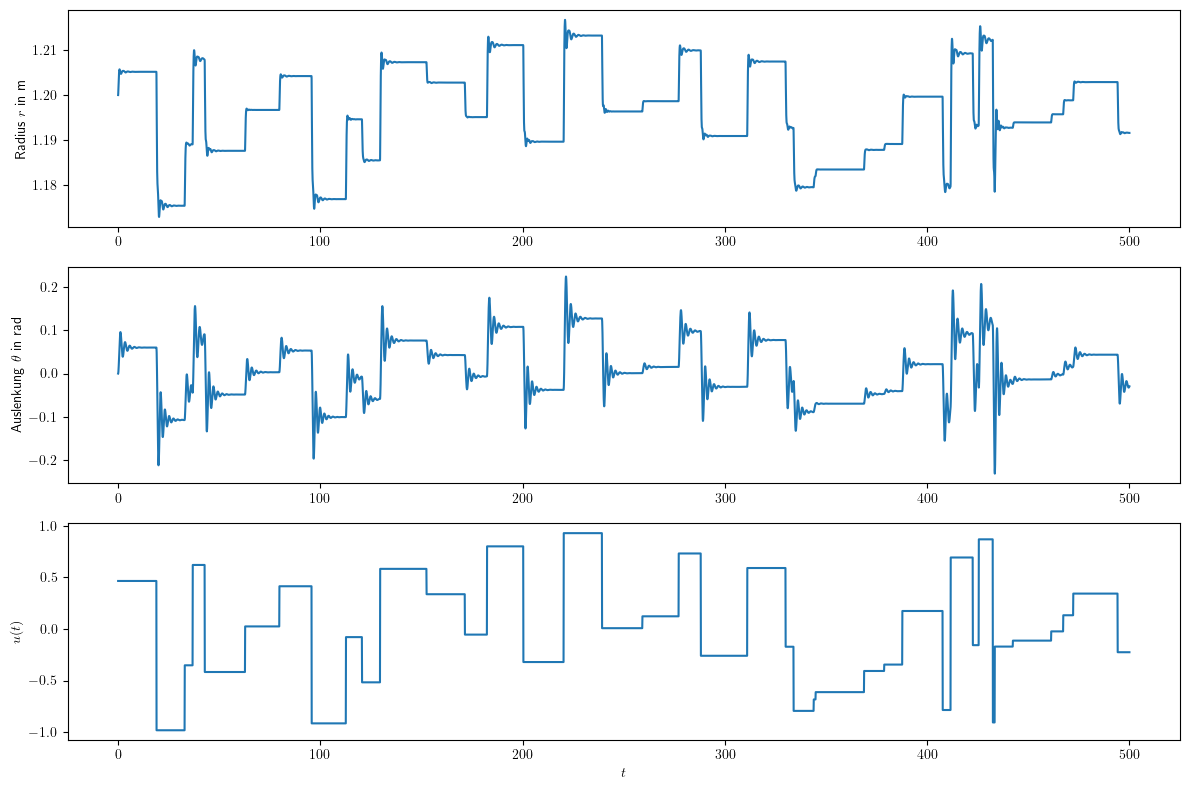

In [217]:
t = np.linspace(0,500,10000)
u = APRBS(t)

u, x, t = runSimulation(t, X0=[1.2,0,0,0])
plot4State(t,x,u,pgf=False)


In [218]:
# neural network

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps"
device = torch.device(device)


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for the RNN cell
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        combined = self.Wxh(x) + self.Whh(h)
        activation = nn.LeakyReLU()
        return activation(combined)


class MultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # Define a list of custom RNN cells
        self.rnn_cells = nn.ModuleList([CustomRNNCell(input_size if i == 0 else hidden_size, hidden_size)
                                        for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #batch_size = x.size(0) #alt, war falsch, wieso auch immer, hat den fehler verursacht mit den hohen dimensionalitaeten
        batch_size = self.batch_size
        #print(f'batch size = {batch_size}')    #zum debuggen benutzt

        # Initialize hidden state with zeros for each layer
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
    
        # Forward through multiple RNN layers
        for layer_idx in range(self.num_layers):
            # Get the current RNN cell
            rnn_cell = self.rnn_cells[layer_idx]

            # Forward through the RNN cell
            hidden_states[layer_idx] = rnn_cell(x if layer_idx == 0 else hidden_states[layer_idx - 1],
                                                hidden_states[layer_idx])

        # Take the output from the last layer
        out = self.fc(hidden_states[-1])
        return out


In [219]:
# initialize the neural network and set hyperparams
number_states = 5
k = 1  # number of timesteps we look back 

input_dim = number_states * k
output_dim = number_states
hidden_dim = 8
num_layers = 2
batch_size = 16
model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers, batch_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
criterion = nn.MSELoss()

In [220]:
t = np.linspace(0,100,1000)
u = APRBS(t)
input_tensor, target_tensor, t = runSimulation(t, torch_tensor=True, batchsize=batch_size)
print(f'input_tensor has shape: {input_tensor.shape}')
print(f'target_tensor has shape: {target_tensor.shape}')

input_tensor has shape: torch.Size([999, 16, 5])
target_tensor has shape: torch.Size([999, 16, 5])


In [221]:
## initiate training phase
number_systems = 5
for i in range(number_systems):
    input_tensor, target_tensor, t = runSimulation(t, torch_tensor=True, batchsize=16)

    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    num_epochs = 800
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_tensor)
        loss = criterion(outputs, target_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'R.{i+1} - - - Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


R.1 - - - Epoch [100/800], Loss: 0.009589931927621365
R.1 - - - Epoch [200/800], Loss: 0.002436706330627203
R.1 - - - Epoch [300/800], Loss: 0.0010467388201504946
R.1 - - - Epoch [400/800], Loss: 0.0007551294402219355
R.1 - - - Epoch [500/800], Loss: 0.0006220900104381144
R.1 - - - Epoch [600/800], Loss: 0.0005261078476905823
R.1 - - - Epoch [700/800], Loss: 0.000452976964879781
R.1 - - - Epoch [800/800], Loss: 0.00042213042615912855
R.2 - - - Epoch [100/800], Loss: 0.000330750917783007
R.2 - - - Epoch [200/800], Loss: 0.00101942615583539
R.2 - - - Epoch [300/800], Loss: 0.00024960943846963346
R.2 - - - Epoch [400/800], Loss: 0.00022120102948974818
R.2 - - - Epoch [500/800], Loss: 0.00038621886051259935
R.2 - - - Epoch [600/800], Loss: 0.0001702422887319699
R.2 - - - Epoch [700/800], Loss: 0.0010128385620191693
R.2 - - - Epoch [800/800], Loss: 0.00013374455738812685
R.3 - - - Epoch [100/800], Loss: 0.0001128225339925848
R.3 - - - Epoch [200/800], Loss: 0.00011505431757541373
R.3 - - - 

In [222]:
### evaluate the model on test set

model.eval()

input_tensor_test, target_tensor_test, t = runSimulation(t, torch_tensor=True, batchsize=batch_size)
input_tensor_test = input_tensor_test.to(device)
target_tensor_test = target_tensor_test.to(device)

# Get predictions from the model
with torch.no_grad():
    predicted_output = model(input_tensor_test)

# Convert predicted_output tensor to numpy array
predicted_output_np = predicted_output.cpu().numpy()
actual_target_np = target_tensor_test.cpu().numpy()

In [223]:
predicted_output_np.shape
actual_target_np.shape

(999, 16, 5)

In [224]:
predicted_output_np[0,0,:]

array([ 1.9691045 , -1.760404  ,  0.41168612,  1.846178  ,  0.9180659 ],
      dtype=float32)

In [225]:
import matplotlib
plt.rcParams["backend"]
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

In [226]:
def plotResults(pgf=False,figsize=(15,10),fontsize=10):
    plt.rcParams.update({'font.size': fontsize})  # Change the global font size
    plt.figure(figsize=figsize)
    k=1
    plt.subplot(2,2,1)
    plt.plot(t[k:],predicted_output_np[:,0,0], label=r'$\hat{x}_1$', linestyle='--')
    plt.plot(t[k:],actual_target_np[:,0,0],label=r"$x_1$")
    plt.xlabel('Time')
    plt.ylabel('Predicted state x1')
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(t[k:],predicted_output_np[:,0,1], label=r'$\hat{x}_2$', linestyle='--')
    plt.plot(t[k:],actual_target_np[:,0,1],label=r"$x_2$")
    plt.xlabel('Time')
    plt.ylabel('Predicted state x2')
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(t[k:],predicted_output_np[:,0,2], label=r'$\hat{x}_3$', linestyle='--')
    plt.plot(t[k:],actual_target_np[:,0,2],label=r"$x_3$")
    plt.xlabel('Time')
    plt.ylabel('Predicted state x3')
    plt.legend()  

    plt.subplot(2,2,4)
    plt.plot(t[k:],predicted_output_np[:,0,3], label=r'$\hat{x}_4$', linestyle='--')
    plt.plot(t[k:],actual_target_np[:,0,3],label=r"$x_4$")
    plt.xlabel('Time')
    plt.ylabel('Predicted state x4')
    plt.legend()

    if pgf:
        plt.switch_backend("pgf")
        name = input("Geben sie den Namen fuer ihren Plot an:")
        name = name + ".pgf"
        plt.savefig(name, format='pgf')
    else:
        plt.switch_backend(stadnard_backend)
        plt.show()

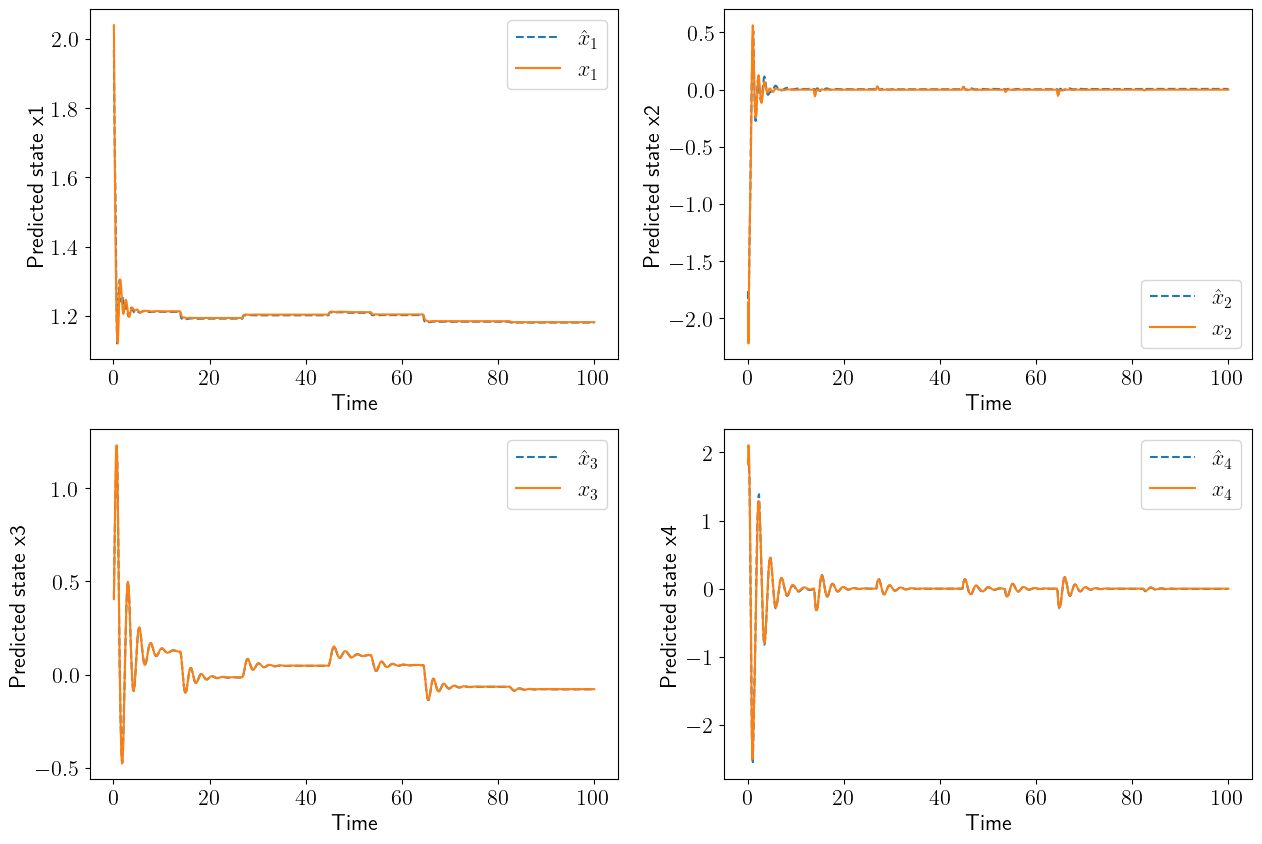

In [227]:
plotResults(pgf=False,fontsize=16)

In [228]:
# run test on different hyperparams
# dic that saves loss for different hyperparams
if False:
    loss_dict = {}
    counter = 0
    hidden_dim_list = [2,4,6]
    num_layers_list = [1,2,3]
    lr_list = [0.01,0.001,0.1]
    num_epochs_list = [500]
    num_systems_list = [5]
    batch_size_list = [8,16]

    amount_hyperparams = len(hidden_dim_list)*len(num_layers_list)*len(lr_list)*len(num_epochs_list)*len(num_systems_list)

    # different hyperparams [hidden_dim, num_layers, lr, num_epochs, num_systems]
    for hidden_dim in hidden_dim_list:
        for num_layers in num_layers_list:
            for lr in lr_list:
                for num_epochs in num_epochs_list:
                    for num_systems in num_systems_list:
                        for batch_size in batch_size_list:

                            model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers, batch_size).to(device)
                            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                            criterion = nn.MSELoss()
                            
                            #counter for which round we are in 
                            counter +=1
                            #### run training phase
                            for i in range(number_systems):
                                input_tensor, target_tensor, t = runSimulation(t, u, torch=True, batchsize=batch_size)

                                input_tensor = input_tensor.to(device)
                                target_tensor = target_tensor.to(device)

                                for epoch in range(num_epochs):
                                    optimizer.zero_grad()

                                    # Forward pass
                                    outputs = model(input_tensor)
                                    loss = criterion(outputs, target_tensor)

                                    # Backward pass and optimization
                                    loss.backward()
                                    optimizer.step()

                                    if (epoch + 1) % (num_epochs/5) == 0:
                                        print(f'Round {i+1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}    ROUND {counter}/{amount_hyperparams}')

                            ### run test phase:
                            avg_loss = 0
                            num_test_iterations = 100
                            for i in range(num_test_iterations):
                                model.eval()

                                input_tensor_test, target_tensor_test, t = runSimulation(1,batch_size)
                                input_tensor_test = input_tensor_test.to(device)
                                target_tensor_test = target_tensor_test.to(device)

                                # Get predictions from the model
                                with torch.no_grad():
                                    predicted_output = model(input_tensor_test)
                                loss = criterion(predicted_output, target_tensor_test)
                                avg_loss += loss.item()
                                
                            loss_dict[(hidden_dim, num_layers, lr, num_epochs, num_systems, batch_size)] = avg_loss/num_test_iterations

                                                

In [ ]:
loss_dict

{(2, 1, 0.01, 500, 5, 8): 0.015930449212901293,
 (2, 1, 0.01, 500, 5, 16): 0.015404886100441217,
 (2, 1, 0.001, 500, 5, 8): 0.030472841607406737,
 (2, 1, 0.001, 500, 5, 16): 0.015973503049463034,
 (2, 1, 0.1, 500, 5, 8): 0.016507566999644042,
 (2, 1, 0.1, 500, 5, 16): 0.09354368353262543,
 (2, 2, 0.01, 500, 5, 8): 0.015724916090257467,
 (2, 2, 0.01, 500, 5, 16): 0.015763824302703143,
 (2, 2, 0.001, 500, 5, 8): 0.02262514762580395,
 (2, 2, 0.001, 500, 5, 16): 0.017422198513522745,
 (2, 2, 0.1, 500, 5, 8): 0.01677796964533627,
 (2, 2, 0.1, 500, 5, 16): 0.015446364944800735,
 (2, 3, 0.01, 500, 5, 8): 0.016587020815350115,
 (2, 3, 0.01, 500, 5, 16): 0.015235641030594707,
 (2, 3, 0.001, 500, 5, 8): 0.023872056631371378,
 (2, 3, 0.001, 500, 5, 16): 0.02816219484433532,
 (2, 3, 0.1, 500, 5, 8): 0.015713317790068685,
 (2, 3, 0.1, 500, 5, 16): 0.06279874462634324,
 (4, 1, 0.01, 500, 5, 8): 5.313814101100434e-05,
 (4, 1, 0.01, 500, 5, 16): 1.441373560737702e-06,
 (4, 1, 0.001, 500, 5, 8): 0.0024

In [ ]:
min_value = min(loss_dict.values())  # Get the minimum value
keys_with_min_value = [key for key, value in loss_dict.items() if value == min_value]  # Get keys with the minimum value

print(f"Lowest value: {min_value} with hyperparams: \nhidden_dim = {keys_with_min_value[0][1]}, \nhidden_layers = {keys_with_min_value[0][1]}, \nlr = {keys_with_min_value[0][2]}, \nepochs = {keys_with_min_value[0][3]}, \nnum_systems = {keys_with_min_value[0][4]}, \nbatch_size = {keys_with_min_value[0][5]}")

Lowest value: 1.441373560737702e-06 with hyperparams: 
hidden_dim = 1, 
hidden_layers = 1, 
lr = 0.01, 
epochs = 500, 
num_systems = 5, 
batch_size = 16


2.5 min for 32 iterations
with epoch 100, 200
num list, 5,10

32*300*15